The aim is to make the following experiments:

* train and test a support vector machine classifier through cross-validation;
* study the effect of the parameter gamma of this classifier using a
  validation curve;
* use a learning curve to determine the usefulness of adding new samples in the dataset when building a classifier.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('transfusion.csv')
df.sample(5)

,Recency,Frequency,Monetary,Time,target
77,2,2,500,4,0
189,4,5,1250,35,1
203,4,7,1750,58,0
726,25,6,1500,50,0
327,14,16,4000,98,0


In [3]:
df.shape

(748, 5)

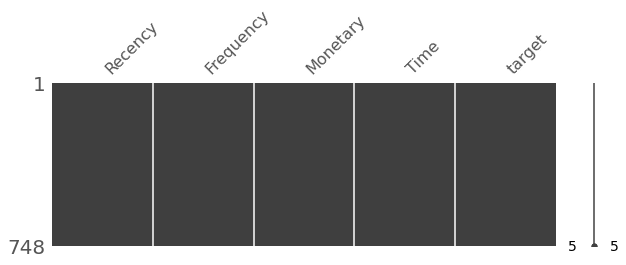

In [4]:
msno.matrix(df, figsize=(10, 3))

In [5]:
data, target = df.drop(columns=['target']), df['target']

In [6]:
target.value_counts()

0    570
1    178
Name: target, dtype: int64

We will use a support vector machine classifier (SVM). In its most simple
form, a SVM classifier is a linear classifier behaving similarly to a logistic regression. Indeed, the optimization used to find the optimal weights of the linear model are different. Also, this classifier can become more flexible/expressive by using a so-called kernel that makes the model become non-linear.

We will use an RBF kernel where a parameter `gamma` allows to tune the
flexibility of the model.

First let's create a predictive pipeline made of:

* a [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
  with default parameter;
* a [`sklearn.svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
  where the parameter `kernel` could be set to `"rbf"`. Note that this is the default.

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

model = make_pipeline(StandardScaler(), SVC(kernel='rbf'))

Evaluate the generalization performance of your model by cross-validation with
a `ShuffleSplit` scheme. Thus, you can use
[`sklearn.model_selection.cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)
and pass a
[`sklearn.model_selection.ShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html)
to the `cv` parameter. Only fix the `random_state=0` in the `ShuffleSplit` and
let the other parameters to the default.


In [8]:
from sklearn.model_selection import ShuffleSplit, cross_validate

cv = ShuffleSplit(n_splits=30, test_size=.33, random_state=0)
cv_results = cross_validate(
    model,
    data,
    target,
    cv=cv,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
)

In [9]:
cv_results = pd.DataFrame(cv_results)
cv_results.head()

,fit_time,score_time,test_score,train_score
0,0.030456,0.009790,0.732794,0.790419
1,0.020965,0.009156,0.757085,0.782435
2,0.018964,0.009029,0.785425,0.788423
3,0.019757,0.009148,0.765182,0.800399
4,0.019532,0.008729,0.753036,0.808383


As previously mentioned, the parameter `gamma` is one of the parameters
controlling under/over-fitting in support vector machine with an RBF kernel.

Evaluate the effect of the parameter `gamma` by using the
[`sklearn.model_selection.validation_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html)
function. You can leave the default `scoring=None` which is equivalent to
`scoring="accuracy"` for classification problems. You can vary `gamma` between
`10e-3` and `10e2` by generating samples on a logarithmic scale with the help
of `np.logspace(-3, 2, num=30)`.

Since we are manipulating a `Pipeline` the parameter name will be set to
`svc__gamma` instead of only `gamma`. You can retrieve the parameter name
using `model.get_params().keys()`. We will go more into detail regarding
accessing and setting hyperparameter in the next section.

In [10]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'svc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [11]:
from sklearn.model_selection import validation_curve

gamma_range= np.logspace(-3, 2, num=30)

train_error, test_error = validation_curve(
    model,
    data,
    target,
    cv=cv,
    scoring='accuracy',
    param_name='svc__gamma',
    param_range= gamma_range,
    n_jobs=-1
)

Plot the validation curve for the train and test scores.

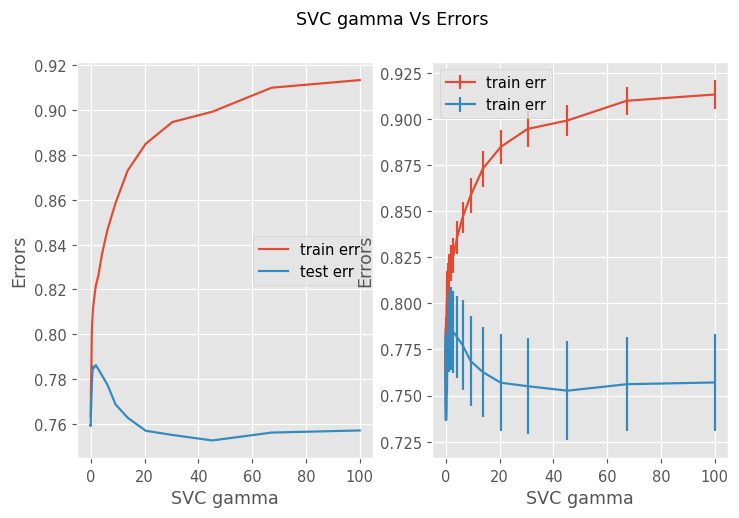

In [12]:
plt.figure(figsize=(8, 5), dpi=105)

plt.subplot(1,2,1)
plt.plot(gamma_range, train_error.mean(axis=1), label='train err')
plt.plot(gamma_range, test_error.mean(axis=1), label='test err')
plt.xlabel('SVC gamma')
plt.ylabel('Errors')
plt.legend()

plt.subplot(1,2,2)
plt.errorbar(
    gamma_range,
    train_error.mean(axis=1),
    yerr=train_error.std(axis=1),
    label='train err' 
)
plt.errorbar(
    gamma_range,
    test_error.mean(axis=1),
    yerr=test_error.std(axis=1),
    label='train err' 
)
plt.xlabel('SVC gamma')
plt.ylabel('Errors')
plt.legend()

plt.suptitle('SVC gamma Vs Errors')
plt.show();